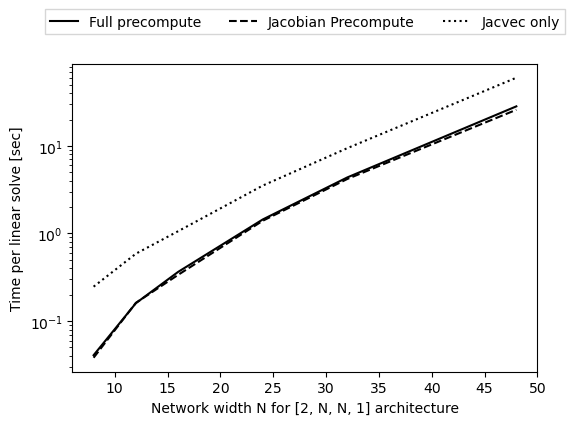

In [2]:
# export XLA_FLAGS=--xla_gpu_force_compilation_parallelism=1
import jax
from jax.scipy.sparse.linalg import cg
import jax.numpy as jnp
from jax import random, grad, vmap, jit
from jax.numpy.linalg import lstsq
import matplotlib.pyplot as plt

import natgrad.mlp as mlp
from natgrad.domains import Square
from natgrad.domains import SquareBoundary, Polygon
from natgrad.integrators import RandomIntegrator, DeterministicIntegrator, EvolutionaryIntegrator
from natgrad.derivatives import laplace
from natgrad.inner import model_laplace, model_identity
from natgrad.gram import gram_factory, nat_grad_factory, nat_grad_factory_generic
from natgrad.utility import grid_line_search_factory
from natgrad.plotting import plot_2d_func, plot_2d_funcs
from natgrad.linalg import sherman_morrison
from jaxopt import LevenbergMarquardt as LMJax
from jaxopt.linear_solve import solve_cg
from natgrad.levenberg_marquardt import LevenbergMarquardt as LM
from natgrad.logger import EventTracker
import numpy as np

jax.config.update("jax_enable_x64", True)



def get_cg_solver(*args, **kwargs):
    def cg_solver(A, b, **kwargs2):
        kwargs2.update(kwargs)
        return solve_cg(A, b, *args, **kwargs)
    return cg_solver

presets = ["LM_full", "LM_semi", "LM_none"]
labels = ["Full precompute", "Jacobian Precompute", "Jacvec only"]
styles = ["solid", "dashed", "dotted"]

Ns = np.array([8, 12, 16, 24, 32, 48])#, 64#, 81])
times = {preset: np.zeros(Ns.shape) for preset in presets}

for i, N in enumerate(Ns):    
    for preset in presets:
        try:
            #data = jnp.load(f"/home/emastr/phd/NaturalGradientTraining/data/state_LM_{preset}_size_{N}_100.npy", allow_pickle=True).item()
            data = jnp.load(f"/home/emastr/phd/NaturalGradientTraining/data/timing_batch_2000_{preset}_{N}.npy", allow_pickle=True).item()
            times[preset][i] = data["time"]
        except:
            continue
        
        

fig = plt.figure(figsize=(6, 4))
#plt.title("Batch size 20, linear solve time vs network size")
#for preset, style in  zip(["LM_semi", "LM_none"], ["dashed", "dotted"]):
for preset, label, ls in zip(times.keys(), labels, styles):
    plt.semilogy(Ns, times[preset] / (128 // Ns).astype(float), color='black', label=label, linestyle=ls)

plt.ylabel("Time per linear solve [sec]")
plt.xlabel("Network width N for [2, N, N, 1] architecture")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=3, fancybox=False, shadow=False)
fig.savefig("/home/emastr/phd/NaturalGradientTraining/experiments/linear_solve_bigbig_time.pdf", bbox_inches='tight')
